In [112]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial import KDTree
from scipy.linalg import sqrtm

In [238]:
p = 3
n = 1000
# locations of observations (1x1 square domain)
s = np.random.rand(n,2)

In [239]:
#K = rbf_kernel(s, s, gamma=1) + 1e-6*np.eye(n)
# Calculate pairwise distances between points
distances = pdist(s, 'euclidean') # Calculates distances in a condensed form
D = squareform(distances) # Converts to a square matrix

K1 = matern_correlation(D, 6, 1.2)
K2 = matern_correlation(D, 1, 1.5)
K3 = matern_correlation(D, 0.25, 1)
z = np.stack([
    np.random.multivariate_normal(np.zeros(n), K1),
    np.random.multivariate_normal(np.zeros(n), K2),
    np.random.multivariate_normal(np.zeros(n), K3)])

# center the data:
z = z - z.mean(axis=1)[:, np.newaxis]

In [240]:
# mixing matrix
O = np.random.normal(size=(p,p))
x = O @ z

# whiten so that SOBIsym works
W = np.linalg.inv(sqrtm(np.cov(x)))
xt = W @ x

In [241]:
# xt is whitened
np.cov(xt)

array([[ 1.00000000e+00,  2.66364619e-15,  2.79167191e-15],
       [ 2.66364619e-15,  1.00000000e+00, -2.31335360e-15],
       [ 2.79167191e-15, -2.31335360e-15,  1.00000000e+00]])

In [242]:
def calculate_local_covariance(points, radius, variables):
    """
    Calculates the covariance matrix for points within a certain radius for each point.

    Args:
        points (np.ndarray): A NumPy array of shape (N, D) where N is the number of
                             points and D is the dimension (e.g., 3 for 3D points).
        radius (float): The radius within which to search for neighbors.
        variables (np.ndarray): a NumPy array of shape (N, P) where P is the dimension
                            of the variables

    Returns:
        np.ndarray: PxP matrix of the covariance
    """
    # Build a KD-Tree for efficient spatial searching
    tree = KDTree(points)
    
    # List to store the covariance matrix for each point
    covariance_matrix = np.zeros((variables.shape[1], variables.shape[1]))
    
    # Iterate over each point
    for i, query_point in enumerate(points):
        # Find indices of points within the specified radius
        neighbor_indices = tree.query_ball_point(query_point, radius)
        #print(query_point, neighbor_indices)
        # Select the neighboring points
        neighbors = variables[neighbor_indices]
        
        covariance_matrix += np.einsum('j, ik -> jk', variables[i], neighbors)
            
    return covariance_matrix / variables.shape[0]

In [211]:
i = 9
r = 0.25
tree = KDTree(s)
ni = tree.query_ball_point(s[i], r)
xt.T[ni]

array([[ 1.7466366 ,  1.4480398 , -0.93586121]])

In [185]:
xt.T[i],xt.T[ni][0]

(array([ 0.43109275, -0.58682407,  0.64072115]),
 array([ 0.43109275, -0.58682407,  0.64072115]))

In [212]:
c += np.outer(xt.T[i], xt.T[ni][0]) #+ np.outer(xt.T[i], xt.T[ni][1]) + np.outer(xt.T[i], xt.T[ni][2]) + np.outer(xt.T[i], xt.T[ni][3])# + np.outer(xt.T[i], xt.T[ni][4])

In [214]:
c/10

array([[ 0.97383536, -0.18341667, -0.11441654],
       [-0.18341667,  1.2371478 ,  0.21270744],
       [-0.11441654,  0.21270744,  2.06456221]])

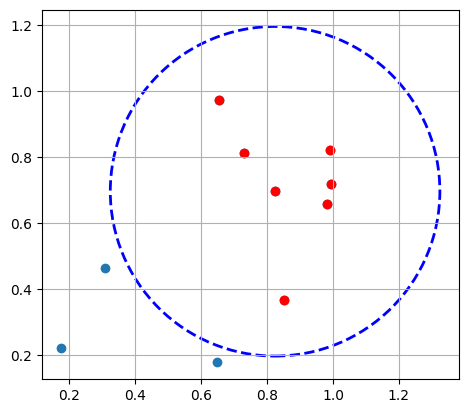

In [174]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.scatter(s.T[0], s.T[1])
ax.scatter(s[ni,0], s[ni,1], c='r')
# Add the circle patch to the axes
ax.add_patch(patches.Circle((s[i,0], s[i,1]), r, fill=False, color='blue', linestyle='--', linewidth=2))
ax.set_aspect('equal', adjustable='box')
plt.grid(True) # Optional: Add a grid
plt.show()

In [119]:
s

array([[0.442407  , 0.5554972 ],
       [0.27708865, 0.35409668],
       [0.1752538 , 0.098684  ],
       [0.71158413, 0.24050541],
       [0.89994393, 0.21534052],
       [0.27181368, 0.9519035 ],
       [0.57889363, 0.05006655],
       [0.16035661, 0.83063481],
       [0.16444443, 0.64413634],
       [0.98540482, 0.01393922]])

In [215]:
M01 = calculate_local_covariance(s, 0.25, xt.T)
M01

array([[ 0.97383536, -0.18341667, -0.11441654],
       [-0.18341667,  1.2371478 ,  0.21270744],
       [-0.11441654,  0.21270744,  2.06456221]])

In [243]:
# calculate local covariance matrices
M01 = calculate_local_covariance(s, 0.25, xt.T)
M005 = calculate_local_covariance(s, 0.1, xt.T)
M0025 = calculate_local_covariance(s, 0.05, xt.T)
M001 = calculate_local_covariance(s, 0.01, xt.T)
M = np.stack((M01, M005, M0025, M001), axis=1)

In [244]:
M.shape

(3, 4, 3)

In [245]:
M

array([[[ 1.13292679e+02,  2.66676809e+01,  9.15102071e+00],
        [ 2.55947999e+01,  4.77581707e+00,  5.72632244e-01],
        [ 7.57018334e+00,  1.16197565e+00,  1.37684384e-01],
        [ 1.32204151e+00, -5.91222734e-03, -2.36916896e-03]],

       [[ 2.66676809e+01,  3.83345463e+01,  1.64341607e+01],
        [ 4.77581707e+00,  1.56995374e+01,  3.93489711e+00],
        [ 1.16197565e+00,  5.67407909e+00,  9.16657351e-01],
        [-5.91222734e-03,  1.31901932e+00,  2.65945169e-02]],

       [[ 9.15102071e+00,  1.64341607e+01,  8.56042347e+01],
        [ 5.72632244e-01,  3.93489711e+00,  2.57022843e+01],
        [ 1.37684384e-01,  9.16657351e-01,  8.05472048e+00],
        [-2.36916896e-03,  2.65945169e-02,  1.29401787e+00]]])

In [246]:
def H(g, S):
    # shape of S (p,k,p)
    return np.tensordot(g, S, axes=([0],[0])) @ g @ (S @ g).T

In [247]:
G = np.eye(p)
for i in range(5000):
    for j in range(p):
        G[j,:] = H(G[j,:], M)
    # orthogonalize
    U, Sigma, V = np.linalg.svd(G)
    G = U @ V.T

In [248]:
# off-diagonals are minimized
G @ M01 @ G.T, G @ M005 @ G.T, G @ M0025 @ G.T, G @ M001 @ G.T

(array([[ 26.93672662,  -1.99204476,   0.17541071],
        [ -1.99204476, 125.98084934,   4.96179778],
        [  0.17541071,   4.96179778,  84.31388357]]),
 array([[12.90075426,  0.90572863,  0.50476565],
        [ 0.90572863, 28.21428812,  1.57070919],
        [ 0.50476565,  1.57070919, 25.88157919]]),
 array([[4.96520365, 0.3525124 , 0.05925349],
        [0.3525124 , 8.27905586, 0.48479239],
        [0.05925349, 0.48479239, 8.05472341]]),
 array([[ 1.30994199e+00, -7.79220363e-05,  3.05003433e-02],
        [-7.79220363e-05,  1.31967063e+00,  1.18550249e-03],
        [ 3.05003433e-02,  1.18550249e-03,  1.30546607e+00]]))

In [249]:
# calculate local covariance matrices
M01 = calculate_local_covariance(s, 0.5, x.T)
M005 = calculate_local_covariance(s, 0.2, x.T)
M0025 = calculate_local_covariance(s, 0.05, x.T)
M001 = calculate_local_covariance(s, 0.01, x.T)
M = np.stack((M01, M005, M0025, M001), axis=1)

In [250]:
G @ W @ M01 @ W.T @ G.T, G @ W @ M005 @ W.T @ G.T, G @ W @ M0025 @ W.T @ G.T, G @ W @ M001 @ W.T @ G.T

(array([[ 16.00031316, -13.90890636,  11.78760038],
        [-13.90890636, 241.92025863, -21.2470596 ],
        [ 11.78760038, -21.2470596 ,  49.0201341 ]]),
 array([[ 2.46104260e+01, -2.54939764e-01, -7.17426770e-02],
        [-2.54939764e-01,  9.08257769e+01,  4.78275593e+00],
        [-7.17426770e-02,  4.78275593e+00,  6.98089530e+01]]),
 array([[4.96520365, 0.3525124 , 0.05925349],
        [0.3525124 , 8.27905586, 0.48479239],
        [0.05925349, 0.48479239, 8.05472341]]),
 array([[ 1.30994199e+00, -7.79220363e-05,  3.05003433e-02],
        [-7.79220363e-05,  1.31967063e+00,  1.18550249e-03],
        [ 3.05003433e-02,  1.18550249e-03,  1.30546607e+00]]))

In [251]:
# G is orthogonal
G @ G.T

array([[ 1.00000000e+00,  3.89190797e-16, -3.12132261e-16],
       [ 3.89190797e-16,  1.00000000e+00,  8.90225903e-18],
       [-3.12132261e-16,  8.90225903e-18,  1.00000000e+00]])

In [48]:
G = G @ W

In [252]:
from scipy.optimize import linear_sum_assignment

def MDI(G):
    Gt = G**2 / (np.linalg.norm(G, axis=1)**2)[:, np.newaxis]
    cost = np.ones_like(Gt) - 2*Gt - (Gt**2).sum(axis=1)[:, np.newaxis]
    row_ind, col_ind = linear_sum_assignment(cost, maximize=False)
    perm = np.argsort(col_ind)
    return (G.shape[0] - (Gt[row_ind, col_ind]).sum())**0.5 / (G.shape[0] - 1)**0.5

In [253]:
MDI(G @ W @ O)

np.float64(0.4913456920509505)

In [254]:
G @ O, G @ W @ O, G @ np.linalg.inv(W) @ O

(array([[-3.46475208e-02,  8.13973066e-01,  1.25857542e+00],
        [-1.51228803e+00, -1.17342039e+00, -1.35991074e-03],
        [ 1.09395981e-01, -1.37042246e+00, -5.15669694e-01]]),
 array([[ 0.47821945, -0.81714888,  1.64728274],
        [-1.96109307, -0.84016842,  0.03178536],
        [ 1.39614735, -4.76942705, -0.09384103]]),
 array([[-0.04122448,  1.02823268,  1.09361367],
        [-1.25841114, -1.13157978, -0.06699704],
        [-0.10598022, -0.79821472, -0.5388664 ]]))

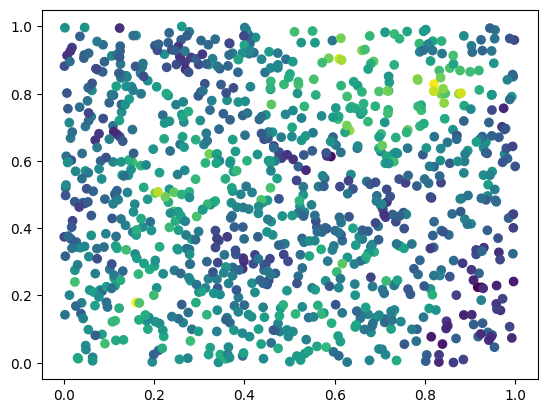

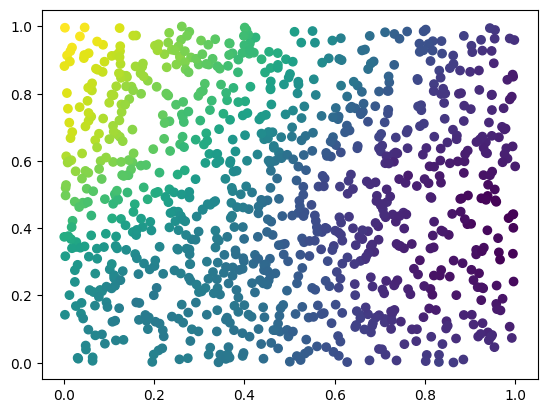

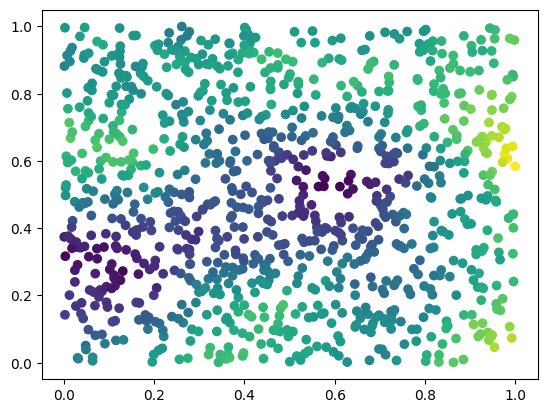

In [258]:
zt = G @ W @ x
plt.scatter(s.T[0], s.T[1], c = zt[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = -1*zt[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = -1*zt[2])
plt.show()

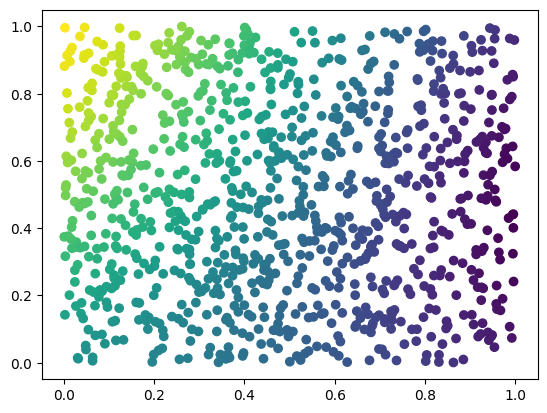

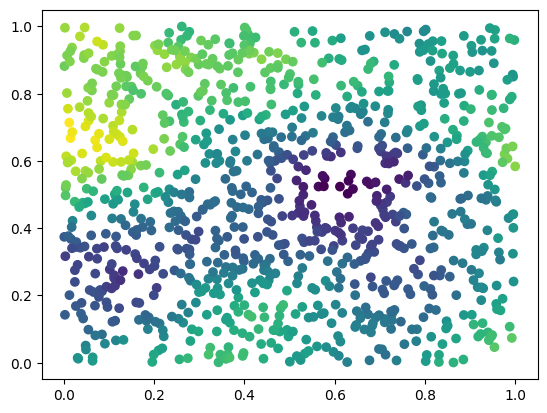

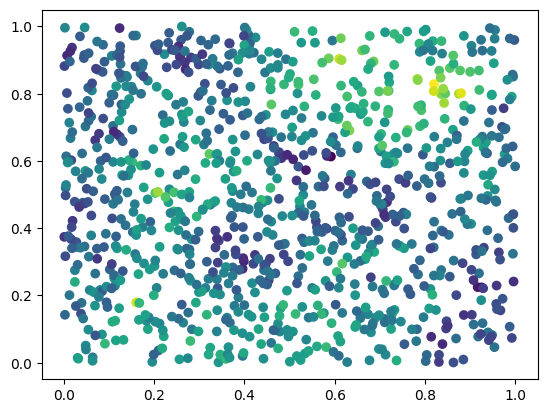

In [255]:
import matplotlib.pyplot as plt
plt.scatter(s.T[0], s.T[1], c = z[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[2])
plt.show()

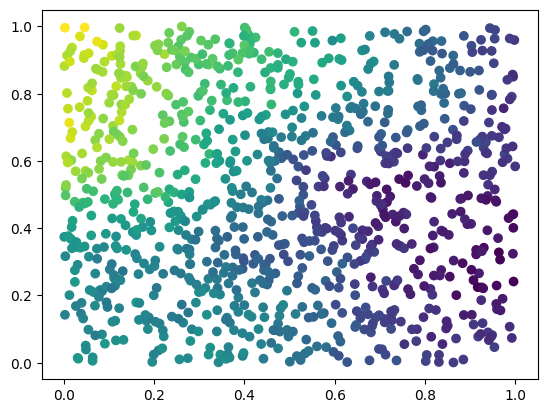

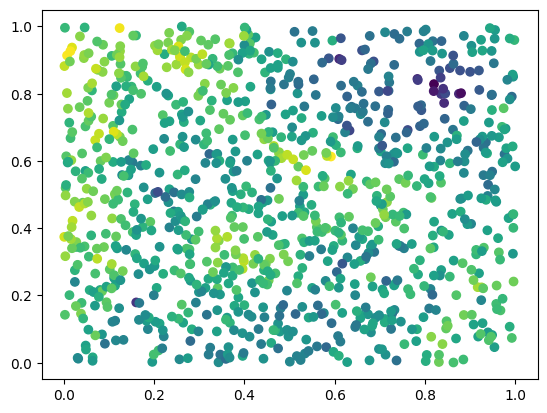

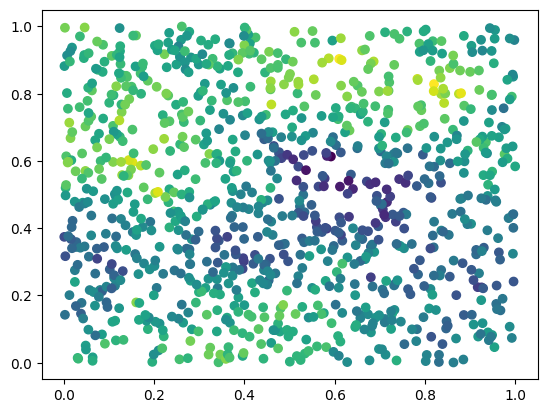

In [256]:
plt.scatter(s.T[0], s.T[1], c = x[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[2])
plt.show()

In [96]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def matern_correlation(distances, nu, length_scale):
    """
    Calculates the Matern correlation function.

    Args:
        distances (np.ndarray): A 1D array of distances between points.
        nu (float): The smoothness parameter of the Matern kernel.
                    Common values are 0.5, 1.5, 2.5, or infinity (for RBF kernel).
        length_scale (float): The characteristic length scale of the correlation.

    Returns:
        np.ndarray: A 1D array of Matern correlation values.
    """
    if nu == 0.5:
        # Exponential kernel (Matern with nu=0.5)
        return np.exp(-distances / length_scale)
    elif nu == 1.5:
        # Matern with nu=1.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(3) * scaled_dist) * np.exp(-np.sqrt(3) * scaled_dist)
    elif nu == 2.5:
        # Matern with nu=2.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(5) * scaled_dist + 5/3 * scaled_dist**2) * np.exp(-np.sqrt(5) * scaled_dist)
    elif np.isinf(nu):
        # Radial Basis Function (RBF) or Squared Exponential kernel (Matern with nu=infinity)
        return np.exp(-0.5 * (distances / length_scale)**2)
    else:
        # General Matern kernel (requires special functions from scipy.special)
        from scipy.special import kv, gamma
        scaled_dist = distances / length_scale
        # Handle the case where scaled_dist is zero to avoid division by zero in kv
        # and ensure correlation is 1 at zero distance.
        correlation = np.zeros_like(scaled_dist)
        non_zero_indices = scaled_dist > 1e-10 # Small epsilon to avoid exact zero
        
        correlation[non_zero_indices] = (2**(1-nu) / gamma(nu)) * \
                                        (np.sqrt(2*nu) * scaled_dist[non_zero_indices])**nu * \
                                        kv(nu, np.sqrt(2*nu) * scaled_dist[non_zero_indices])
        correlation[~non_zero_indices] = 1.0 # Correlation is 1 at zero distance
        return correlation

# Calculate pairwise distances between points
distances = pdist(s, 'euclidean') # Calculates distances in a condensed form
distance_matrix = squareform(distances) # Converts to a square matrix

# Set Matern parameters
nu_val = 1.5  # Smoothness parameter
length_scale_val = 0.25 # Length scale

# Calculate the Matern correlation matrix
matern_corr_matrix = matern_correlation(distance_matrix, nu_val, length_scale_val)

In [55]:
O

array([[ 0.88612786, -0.78239732, -0.40480609],
       [-0.14833105,  0.14365404,  0.50107971],
       [ 0.10145457,  0.13766992,  0.82782492]])